In [1]:
import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind, ttest_rel, wilcoxon, shapiro
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density # needed for density scatter plots
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# COLORS:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#440053"),
    (0.2, "#404388"),
    (0.4, "#2a788e"),
    (0.6, "#21a784"),
    (0.8, "#78d151"),
    (1, "#fde624"),
], N=256)
# "Viridis-like" colormap with white background
white_viridis_r = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#fde624"),
    (0.4, "#78d151"),
    (0.6, "#21a784"),
    (0.7, "#2a788e"),
    (0.8, "#404388"),
    (1, "#440053"),
], N=256)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

rng = np.random.RandomState(47)

In [2]:
# Download thse from Zenodo (https://zenodo.org/uploads/13823014)

#print(
#    "scp cbsu:/fs/cbsubscb17/storage/projects/CLIPNET_transfer/k562_siraj_mpra/k562_allelic_mpra_snps.csv.gz ~/github/scratch/siraj_mpra"
#)
#print(
#    "scp cbsu:/home2/ayh8/clipnet_k562/data/mpra/media-3_oligos_snps_cleaned_enformer_windows_holdouts.bed.gz \
#        ~/github/scratch/siraj_mpra"
#)
#print(
#    "scp cbsu:/home2/ayh8/clipnet_k562/data/mpra/k562_mpra_snps_enformer_center.npz ~/github/scratch/siraj_mpra"
#)

In [3]:
cnn = pd.read_csv("/Users/adamhe/github/scratch/k562_allelic_mpra_snps_exp.csv.gz")

In [4]:
cnn = cnn[np.isfinite(cnn["log2fc_clipnet_holdout"])]
cnn = cnn[
    [
        "fold", "variant", "emVar_K562", "active_K562", "log2fc_expt",
        "log2fc_clipnet_ensemble", "log2fc_clipnet_holdout", "log2fc_procapnet_ensemble",
        "log2fc_clipnet_reference_ensemble",
    ]
]
cnn = cnn[np.isfinite(cnn["log2fc_clipnet_holdout"])]
cnn.dropna(inplace=True)
cnn = cnn[cnn.active_K562 == 1]

In [5]:
enformer_pred = np.load("/Users/adamhe/github/scratch/siraj_mpra/k562_mpra_snps_enformer_center.npz")
enformer_variants = pd.read_csv(
    "/Users/adamhe/github/scratch/siraj_mpra/media-3_oligos_snps_cleaned_enformer_windows_holdouts.bed.gz",
    sep="\t",
    header=None
).iloc[:, 3]

In [6]:
enformer_log2fc = pd.DataFrame(
    np.log2(enformer_pred["ref"].mean(axis=1) / enformer_pred["alt"].mean(axis=1))
)
enformer_log2fc.columns = [f"enformer_{i}" for i in range(enformer_log2fc.shape[1])]
enformer_log2fc["variant"] = enformer_variants

In [8]:
data = cnn.merge(enformer_log2fc, on="variant", suffixes=("", "_enformer"))
data.emVar_K562.value_counts()

emVar_K562
0.0    4057
1.0    2038
Name: count, dtype: int64

In [9]:
print(average_precision_score(data.emVar_K562, data.log2fc_clipnet_ensemble ** 2))
print(average_precision_score(data.emVar_K562, data.log2fc_clipnet_reference_ensemble ** 2))
print(average_precision_score(data.emVar_K562, data.log2fc_procapnet_ensemble ** 2))
print(average_precision_score(data.emVar_K562, data.enformer_4 ** 2))

0.4903219497676783
0.4812074089850219
0.4406803560861765
0.4095665718627676


In [10]:
print(average_precision_score(data.emVar_K562, data.log2fc_clipnet_ensemble ** 2))
print(average_precision_score(data.emVar_K562, data.log2fc_clipnet_reference_ensemble ** 2))
print(average_precision_score(data.emVar_K562, data.log2fc_procapnet_ensemble ** 2))
print(average_precision_score(data.emVar_K562, data.enformer_4 ** 2))
for i in range(9):
    print(average_precision_score(data.emVar_K562, data[f"enformer_{i}"] ** 2))

0.4903219497676783
0.4812074089850219
0.4406803560861765
0.4095665718627676
0.40182364690544503
0.4031036671045944
0.4029258446844746
0.40820762797225263
0.4095665718627676
0.4044861626624813
0.40043842028199983
0.37192103351137473
0.3650324111685055


In [14]:
procapnet_map_bootstrap = []
clipnet_map_bootstrap = []
clipnet_reference_map_bootstrap = []
enformer_map_bootstrap = []
random_map_bootstrap = []

for i in range(1000):
    emvar, clipnet, clipnet_reference, procapnet, enformer = resample(
        data.emVar_K562,
        data.log2fc_clipnet_holdout ** 2,
        data.log2fc_clipnet_reference_ensemble ** 2,
        data.log2fc_procapnet_ensemble ** 2,
        data.enformer_4 ** 2,
        random_state=rng
    )
    clipnet_map_bootstrap.append(average_precision_score(emvar, clipnet))
    clipnet_reference_map_bootstrap.append(average_precision_score(emvar, clipnet_reference))
    procapnet_map_bootstrap.append(average_precision_score(emvar, procapnet))
    enformer_map_bootstrap.append(average_precision_score(emvar, enformer))
    random_map_bootstrap.append(average_precision_score(emvar, rng.rand(emvar.shape[0])))

In [15]:
bootstraps = pd.DataFrame(
    {
        "clipnet": clipnet_map_bootstrap,
        "clipnet_reference": clipnet_reference_map_bootstrap,
        "procapnet": procapnet_map_bootstrap,
        "enformer": enformer_map_bootstrap,
        "random": random_map_bootstrap,
    }
)
bootstraps_delta = bootstraps.sub(bootstraps["clipnet"], axis=0)

In [16]:
(bootstraps_delta["clipnet_reference"] > 0).mean()

0.032

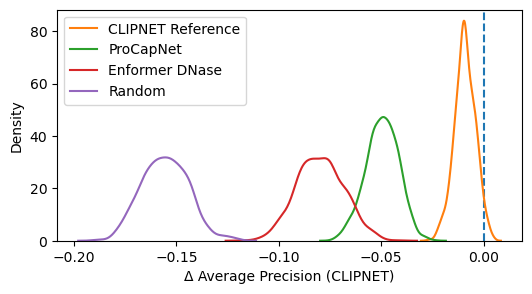

In [17]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 1, 1)
plt.axvline(x=0, color=colors[0], linestyle="--")
sns.kdeplot(bootstraps_delta["clipnet_reference"], label="CLIPNET Reference", color=colors[1])
sns.kdeplot(bootstraps_delta["procapnet"], label="ProCapNet", color=colors[2])
sns.kdeplot(bootstraps_delta["enformer"], label="Enformer DNase", color=colors[3])
sns.kdeplot(bootstraps_delta["random"], label="Random", color=colors[4])
plt.xlabel("Δ Average Precision (CLIPNET)")
plt.ylabel("Density")
#plt.xticks([-0.25, -0.125, 0.0])
#plt.yticks([0, 40])
plt.legend()
plt.savefig("img/emVar_average_precision_bootstrap.pdf")

In [18]:
def prc(y_true, y_scores):
    """
    Calculates precision and recall for different thresholds.

    Args:
        y_true (array-like): True binary labels.
        y_scores (array-like): Predicted probabilities or scores.

    Returns:
        precision (array): Precision values for different thresholds.
        recall (array): Recall values for different thresholds.
        thresholds (array): Thresholds used to calculate precision and recall.
    """

    precision, recall, thresholds = [], [], []
    unique_thresholds = np.unique(y_scores)

    for threshold in unique_thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        if tp + fp > 0:
            precision.append(tp / (tp + fp))
        else:
            precision.append(1)

        if tp + fn > 0:
            recall.append(tp / (tp + fn))
        else:
            recall.append(0)

        thresholds.append(threshold)

    return precision, recall, thresholds

# Compute precision and recall
precision, recall, _ = prc(data.emVar_K562, data.log2fc_clipnet_ensemble ** 2)
precision1, recall1, _ = prc(data.emVar_K562, data.log2fc_clipnet_reference_ensemble ** 2)
precision2, recall2, _ = prc(data.emVar_K562, data.log2fc_procapnet_ensemble ** 2)
precision3, recall3, _ = prc(data.emVar_K562, data.enformer_4 ** 2)
rand_precision, rand_recall, _ = prc(data.emVar_K562, np.random.uniform(0, 1, len(data)))

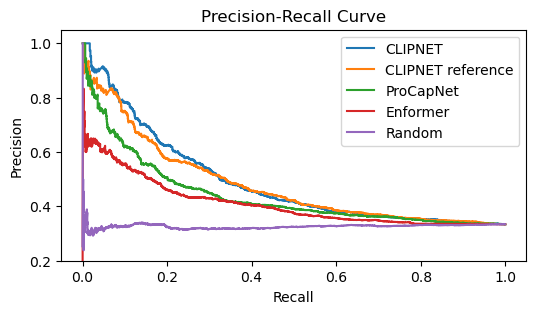

In [19]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 1, 1)

# Plot Precision-Recall Curve
plt.plot(recall, precision)
plt.plot(recall1, precision1)
plt.plot(recall2, precision2)
plt.plot(recall3, precision3)
plt.plot(rand_recall, rand_precision)#, linestyle='--')
plt.ylim(0.2, 1.05)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(["CLIPNET", "CLIPNET reference", "ProCapNet", "Enformer", "Random"])
plt.savefig("img/emVar_prc.pdf")